#구글 코랩에 캐글 데이터셋(MNIST) 내려받기

In [1]:
# MNIST 데이터셋 로드
import tensorflow as tf
import tensorflow_datasets as tfds

dataset, info = tfds.load('MNIST', with_info=True, as_supervised=False)
train_dataset_original = dataset['train']
test_datasets = dataset['test']

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [2]:
# 훈련 데이터셋과 검증 데이터셋으로 나누기
train_datasets = train_dataset_original.take(50000)
valid_datasets = train_dataset_original.skip(50000)

In [3]:
print(len(train_datasets))
print(len(valid_datasets))
print(len(test_datasets))

50000
10000
10000


In [4]:
for data in train_datasets.take(5):
  print(data['image'].shape)
  print(data['label'])

(28, 28, 1)
tf.Tensor(4, shape=(), dtype=int64)
(28, 28, 1)
tf.Tensor(1, shape=(), dtype=int64)
(28, 28, 1)
tf.Tensor(0, shape=(), dtype=int64)
(28, 28, 1)
tf.Tensor(7, shape=(), dtype=int64)
(28, 28, 1)
tf.Tensor(8, shape=(), dtype=int64)


# 데이터 전처리

In [5]:
# 데이터 전처리 함수
def preprocessing(data):
  image = tf.cast(data['image'], tf.float32) / 255.0
  label = data['label']
  return image, label

In [6]:
# 전처리를 train_datasets에 매핑하기
BATCH_SIZE=64
train_data = train_datasets.map(preprocessing).shuffle(1000).batch(BATCH_SIZE)
valid_data = valid_datasets.map(preprocessing).batch(BATCH_SIZE)
test_data = test_datasets.map(preprocessing).batch(BATCH_SIZE)

In [7]:
# train_data에서 하나 추출하여 shape 확인
for image, label in train_data.take(1):
  print(image.shape)
  print(label.shape)

(64, 28, 28, 1)
(64,)


# 데이터 증식 사용하기

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

In [9]:
# 데이터 증식 단계 정의
data_augmentation = keras.Sequential(
    [
        layers.RandomRotation(0.05), # 0.1 -> 0.05
        layers.RandomZoom(0.15) # 0.2 -> 0.15
    ]
)

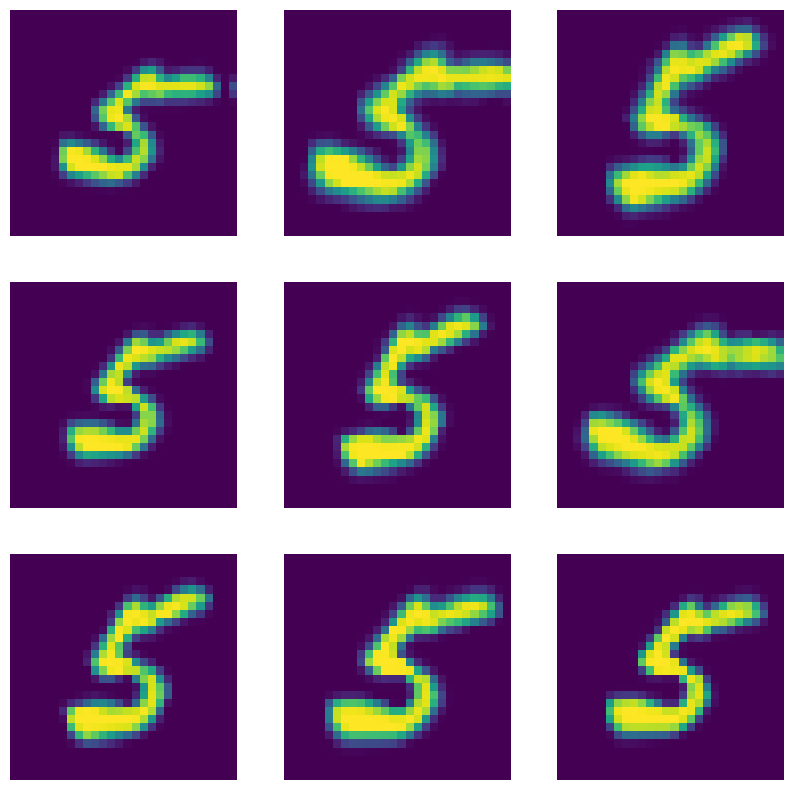

In [10]:
# 랜덤 증식된 훈련 이미지 출력하기
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for image, _ in train_data.take(1):
  for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_image[0].numpy().astype("float32"))
    plt.axis("off")

# 모델 만들기

In [11]:
# 컨브넷 모델 만들기
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(28, 28, 1))
x = data_augmentation(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation = "relu")(x) # 새롭게 추가한 layer
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [12]:
#모델 요약
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                        

In [13]:
# 모델 컴파일, 옵티마이저인 adam의 학습률 변경
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5) # 1e-3 -> 3e-5
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics="accuracy")

# 모델 훈련하기, 평가하기

In [14]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=5) # 3 -> 5
]
history = model.fit(
    train_data,
    validation_data=(valid_data),
    epochs=30, # 10 -> 30
    callbacks=callbacks)

Epoch 1/30
782/782 [==============================] - 21s 15ms/step - loss: 1.3058 - accuracy: 0.6437 - val_loss: 0.4398 - val_accuracy: 0.8785
Epoch 2/30
782/782 [==============================] - 6s 8ms/step - loss: 0.4603 - accuracy: 0.8679 - val_loss: 0.2776 - val_accuracy: 0.9214
Epoch 3/30
782/782 [==============================] - 7s 9ms/step - loss: 0.3414 - accuracy: 0.8993 - val_loss: 0.2148 - val_accuracy: 0.9385
Epoch 4/30
782/782 [==============================] - 6s 7ms/step - loss: 0.2816 - accuracy: 0.9169 - val_loss: 0.1809 - val_accuracy: 0.9497
Epoch 5/30
782/782 [==============================] - 7s 9ms/step - loss: 0.2382 - accuracy: 0.9296 - val_loss: 0.1541 - val_accuracy: 0.9570
Epoch 6/30
782/782 [==============================] - 6s 8ms/step - loss: 0.2094 - accuracy: 0.9386 - val_loss: 0.1382 - val_accuracy: 0.9620
Epoch 7/30
782/782 [==============================] - 7s 9ms/step - loss: 0.1886 - accuracy: 0.9445 - val_loss: 0.1272 - val_accuracy: 0.9651
Epoc

<Figure size 640x480 with 0 Axes>

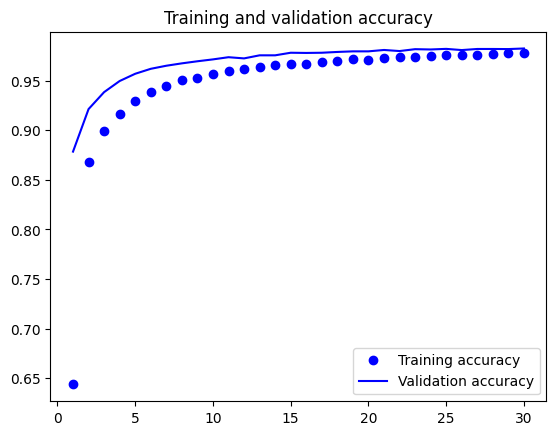

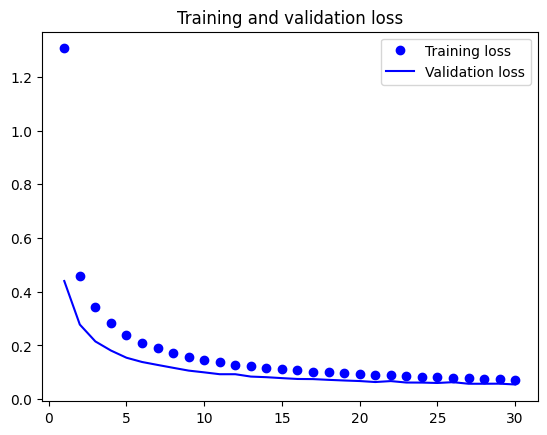

<Figure size 640x480 with 0 Axes>

In [15]:
# 훈련 과정 정확도, 손실 그래프 그리기
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy)+1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.figure()

In [16]:
# 테스트 세트에서 모델 평가하기
import time

test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
start_time = time.time()
test_loss, test_acc = test_model.evaluate(test_data)
end_time = time.time()
prediction_time = end_time - start_time
print(f"테스트 정확도: {test_acc:.3f}")
print(f"prediction time : {prediction_time:.3f} s")

157/157 [==============================] - 1s 6ms/step - loss: 0.0399 - accuracy: 0.9863
테스트 정확도: 0.986
prediction time : 1.542 s
